The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


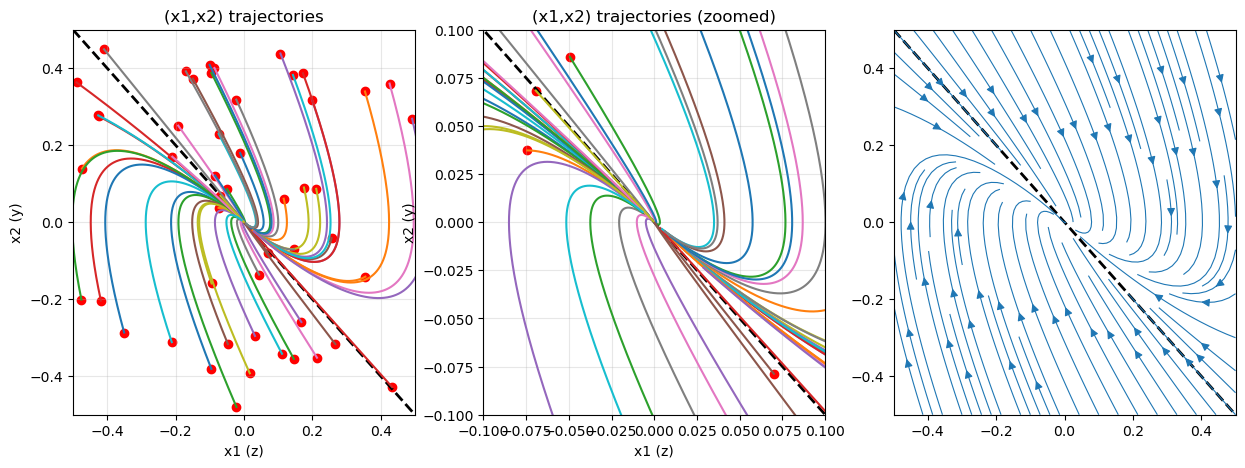

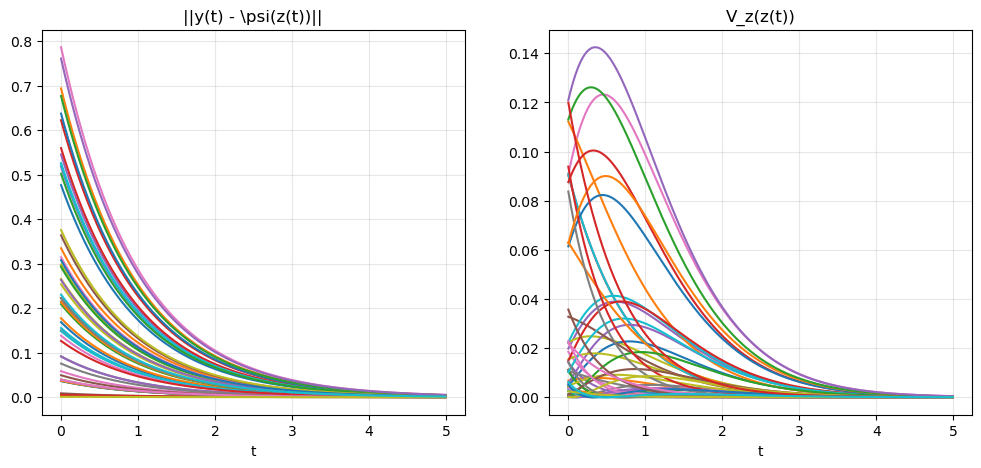

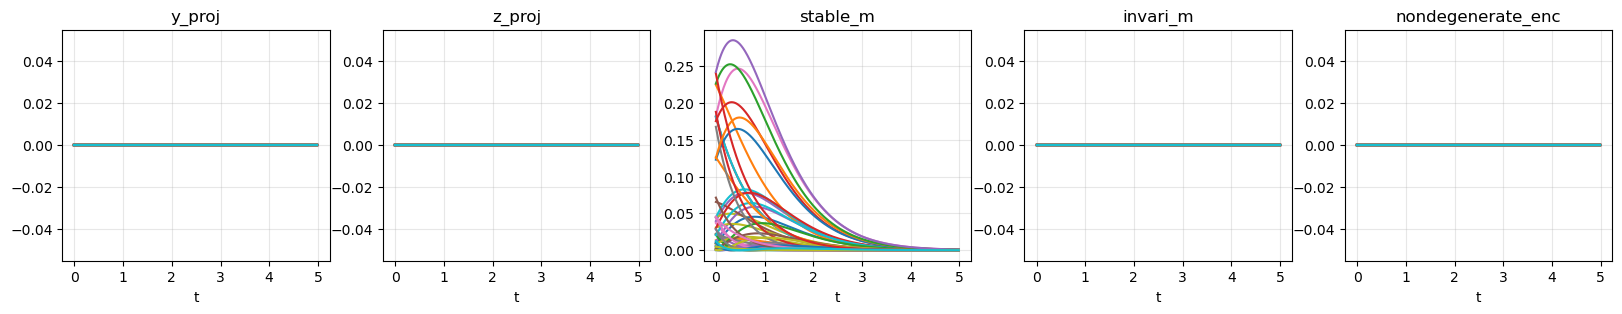

In [3]:
%load_ext autoreload
%autoreload 2

import os, sys
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax, flax
from einops import rearrange
from double_integrator import *


box_width = 0.5

cfg_rom = CfgDIROM()
cfg_rollout = CfgRollout()
rng = jax.random.PRNGKey(42)

params = flax.core.FrozenDict({}) # place holder for NN parameters
ts = jnp.arange(cfg_rollout.t0, cfg_rollout.t1 + cfg_rollout.dt, cfg_rollout.dt)
x0s = jax.random.uniform(rng, (50, 2), minval=-box_width, maxval=box_width)

integrator = Integrator(
    solver=partial(dfx.diffeqsolve, solver=dfx.Tsit5()),
    ts=ts,
    rom=DoubleIntegratorROM(cfg_rom=cfg_rom)
)

ret = integrator.apply(x0s)
aux_ret, loss_ret = integrator.post_apply(ret)

def make_plots(ret, aux_ret, loss_ret):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.set_xlim(-box_width, box_width)
    ax1.set_ylim(-box_width, box_width)
    ax2.set_xlim(-0.1, 0.1)
    ax2.set_ylim(-0.1, 0.1)
    ax1.set_title('(x1,x2) trajectories')
    ax2.set_title('(x1,x2) trajectories (zoomed)')

    for ax in (ax1, ax2):
        ax.set_xlabel('x1 (z)')
        ax.set_ylabel('x2 (y)')
        ax.grid(True, alpha=0.3)

    # Zero dynamics line
    x1s = jnp.linspace(-box_width, box_width, 100)
    x2s = -cfg_rom.kpsi * x1s
    for ax in (ax1, ax2, ax3):
        ax.plot(x1s, x2s, 'k--', linewidth=2, label='Zero dynamics line')

    # rollout trajectories
    for ax in (ax1, ax2):
        for i in range(ret.xs.shape[0]):
            ax.plot(ret.xs[i, :, 0], ret.xs[i, :, 1])
            ax.scatter(ret.xs[i, 0, 0], ret.xs[i, 0, 1], color='red')
            
    # streamplot
    N = 100
    X1, X2 = jnp.meshgrid(
        jnp.linspace(-box_width, box_width, N),
        jnp.linspace(-box_width, box_width, N),
        indexing='xy'
    )
    U = X2
    V = jax.vmap(integrator.rom.policy_v, in_axes=(0, 0))(
        rearrange(X2, 'n1 n2 -> (n1 n2)'), rearrange(X1, 'n1 n2 -> (n1 n2)')
    )
    V = rearrange(V.squeeze(), '(n1 n2) -> n1 n2', n1=N, n2=N)
    X1n, X2n, Un, Vn = map(np.asarray, (X1, X2, U, V))
    ax3.streamplot(X1n, X2n, Un, Vn, density=1.2, linewidth=0.8, arrowsize=1.2, minlength=0.2)
            
    plt.show()

    # M_\psi error
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.set_title(r'||y(t) - \psi(z(t))||')
    ax1.set_xlabel('t')
    ax1.grid(True, alpha=0.3)
    ax2.set_title(r'V_z(z(t))')
    ax2.set_xlabel('t')
    ax2.grid(True, alpha=0.3)

    for i in range(aux_ret.xs.shape[0]):
        ax1.plot(aux_ret.ts[:-1], aux_ret.es[i])
        ax2.plot(aux_ret.ts[:-1], aux_ret.lyaps[i])
        
    
    
    attrs = ["y_proj", "z_proj", "stable_m", "invari_m", "nondegenerate_enc"]
    fig, axes = plt.subplots(1, len(attrs), figsize=(4*len(attrs), 3))
    for ax, attr in zip(axes, attrs):
        ax.set_title(attr)
        ax.set_xlabel('t')
        ax.grid(True, alpha=0.3)
        
        for i in range(aux_ret.xs.shape[0]):
            ax.plot(aux_ret.ts[:-1], getattr(loss_ret, attr)[i])

    plt.show()

make_plots(ret, aux_ret, loss_ret)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1,) (50, 1)


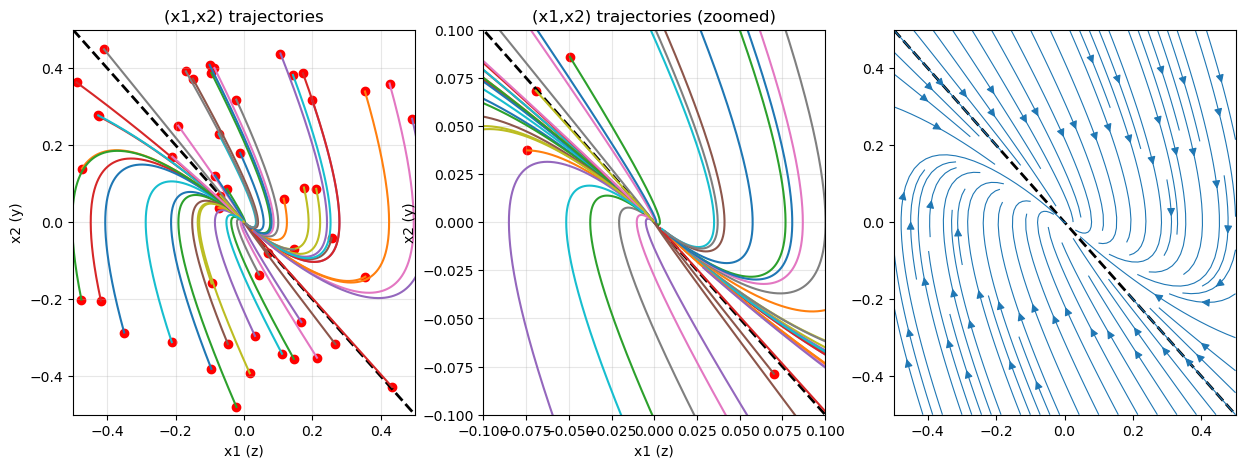

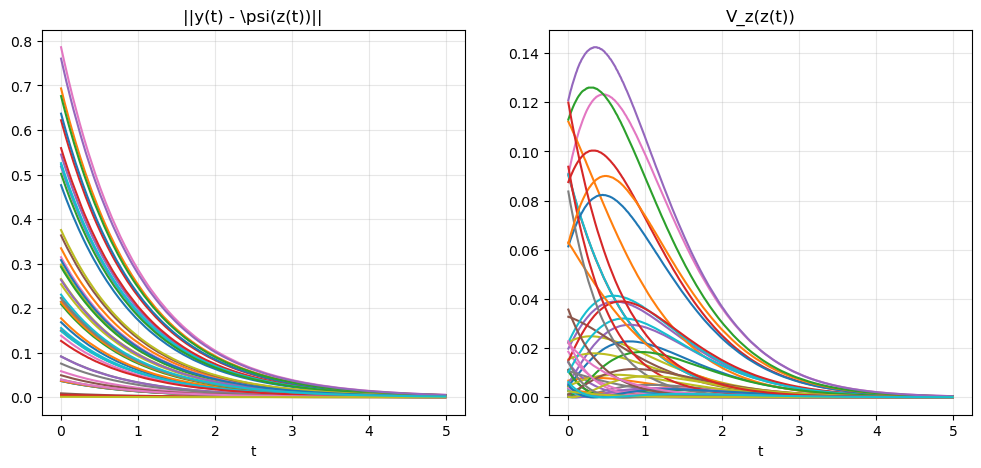

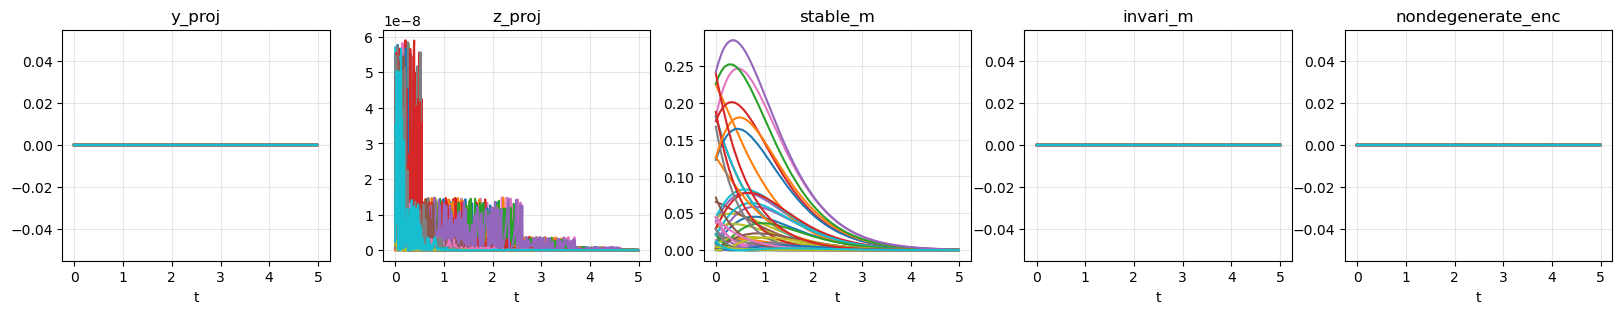

In [4]:
%load_ext autoreload
%autoreload 2


import os, sys
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax, flax
from double_integrator import *


box_width = 0.5

cfg_rom = CfgDIROM()
cfg_rollout = CfgRollout()
rng = jax.random.PRNGKey(42)

params = flax.core.FrozenDict({}) # place holder for NN parameters
ts = jnp.arange(cfg_rollout.t0, cfg_rollout.t1 + cfg_rollout.dt, cfg_rollout.dt)
x0s = jax.random.uniform(rng, (50, 2), minval=-box_width, maxval=box_width)

rom = NNDoubleIntegratorROM(cfg_rom=cfg_rom)
rom.hardcode_nn_params()

integrator = Integrator(
    solver=partial(dfx.diffeqsolve, solver=dfx.Tsit5()),
    ts=ts,
    rom=rom
)



ret1 = rom.policy_v(1.0, 1.0)
ret2 = jax.vmap(rom.policy_v, in_axes=(0, 0))(
    jnp.ones((50,)),
    jnp.ones((50,))
)

print(ret1.shape, ret2.shape)

ret = integrator.apply(x0s)
aux_ret, loss_ret = integrator.post_apply(ret)
make_plots(ret, aux_ret, loss_ret)

    

In [4]:
rom.get_nn_params()

{'nn_encoder': {'kernel': Array([[0., 1.],
         [1., 0.]], dtype=float32),
  'bias': None},
 'nn_decoder': {'kernel': Array([[0., 1.],
         [1., 0.]], dtype=float32),
  'bias': None},
 'nn_fy': {'kernel': Array([[0.]], dtype=float32), 'bias': None},
 'nn_gy': {'kernel': Array([[0.]], dtype=float32),
  'bias': Array([1.], dtype=float32)},
 'nn_fz': {'kernel': Array([[1.],
         [0.]], dtype=float32),
  'bias': None},
 'nn_psi': {'kernel': Array([[1.]], dtype=float32), 'bias': None}}